Image Colorization is a classic problem of Computer Vision which deals with adding color to a Grayscale image. In this project we will explore a number of approaches to the problem including implementing a GAN.

In [0]:
#Import block

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision.utils import save_image
from PIL import Image
from skimage import color
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import glob
import os
import pathlib
from random import shuffle
import pickle
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
if not os.path.isdir('/content/tom_and_jerry'):
    !cp -r '/content/drive/My Drive/Machine Learning - Google Colab/Image Colorization/data/tom_and_jerry.tar' /content
    !tar -xvf /content/tom_and_jerry.tar
    !rm /content/tom_and_jerry.tar

In [0]:
#Total Items : 1596
#Train Set : 1276

In [0]:
#Global variables
dataset = 'tom_and_jerry'
folder = 'Unet_200_b5'
data_path = '/content/{}'.format(dataset)
global_path = '/content/drive/My Drive/Machine Learning - Google Colab/Image Colorization/{}/{}'.format(dataset,folder)
image_format = 'jpg'
image_size = 256
batch_size = 5
lamda = 200
batches_iter = 256

In [0]:
class CustomDataset(Dataset):
    def __init__(self, path, image_size, image_format = 'png'):
        
        self.root = path
        self.image_size = image_size
        
        path_loc = pathlib.Path(path)
        if(not path_loc.exists()):
            raise Exception('The path provided is incorrect!')
        
        searchstring = os.path.join(path,'*.'+image_format)
        list_of_images = glob.glob(searchstring)
        
        self.image_paths = list_of_images
    
    def __getitem__(self, index):
        file_path = self.image_paths[index]
        img =  self.load_image(file_path)
        img = img.resize((self.image_size, self.image_size))
        img_np = np.array(img)
        
        #Scale the values to range -1 to 1
        img_np = (img_np - 127.5)/127.5
        
        lab_img = color.rgb2lab(img)
        
        img_np = np.transpose(img_np,(2,0,1))
        lab_img = np.transpose(lab_img, (2,0,1))
        
        img_l = lab_img[0,:,:]/100
        size = img_l.shape
        
        return (torch.FloatTensor(img_l).view(-1,size[0],size[1]), torch.FloatTensor(img_np))
        
    def __len__(self):
        return len(self.image_paths)
    
    def load_image(self, file_path):
        with open(file_path,'rb') as file:
            with Image.open(file) as img:
                return img.convert('RGB')
    
    def __str__(self):
        return 'Dataset details are - \nRoot Location : {}\nImage Size : {}\nSize : {}\nTransforms : ToTensor and Normalize (RGB Image from -1 to 1 and Grayscale Image from 0 to 1)'.format(self.root,self.image_size, self.__len__())

In [0]:
class Dataloader:
    def __init__(self, path, image_size, batch_size = 16, image_format = 'png', validation_required = (False, 0.2, None)):
        self.path = path
        self.image_size = image_size
        self.image_format = image_format
        self.validation_req = validation_required
        self.batch_size = batch_size
    
    def get_data_loader(self, load_indexes = False, save_indexes = False):
        dataset = CustomDataset(self.path, self.image_size, self.image_format)
        print(dataset)
        size = len(dataset)
        
        train_index = list(range(size))
        valid_index = []
        
        if self.validation_req[0]:
            file_path = '{}/{}'.format(self.path, self.validation_req[2])
            if load_indexes:
                with open(file_path, 'rb') as file:
                    save_dict = pickle.load(file)
                    train_index = save_dict['train']
                    valid_index = save_dict['valid']
                    print('Index files have been loaded!')
            else:
                train_size = int(size*(1- self.validation_req[1]))
                indexes = list(range(size))
                shuffle(indexes)
                train_index = indexes[0:train_size]
                valid_index = indexes[train_size:]

                if save_indexes:
                    with open(file_path, 'wb') as file:
                        save_dict = {'train' : train_index, 'valid' : valid_index}
                        pickle.dump(save_dict, file)
                        print('Index files have been saved!')

        train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
        valid_sampler = torch.utils.data.SubsetRandomSampler(valid_index)
        
        trainloader = None
        validloader = None
        if (len(valid_index) == 0):
            trainloader = torch.utils.data.DataLoader(dataset, shuffle= True, batch_size= self.batch_size)
        else:
            trainloader = torch.utils.data.DataLoader(dataset, sampler= train_sampler, batch_size= self.batch_size)
            validloader = torch.utils.data.DataLoader(dataset, sampler= valid_sampler, batch_size= 1)
        
        return (trainloader, validloader)

In [7]:
loader = Dataloader(data_path, image_size, batch_size= batch_size, image_format= image_format, validation_required = (True, 0.2, 'train_validation_split'))
trainloader, validloader = loader.get_data_loader(load_indexes= True)

Dataset details are - 
Root Location : /content/tom_and_jerry
Image Size : 256
Size : 1596
Transforms : ToTensor and Normalize (RGB Image from -1 to 1 and Grayscale Image from 0 to 1)
Index files have been loaded!


torch.Size([5, 1, 256, 256])
torch.Size([5, 3, 256, 256])


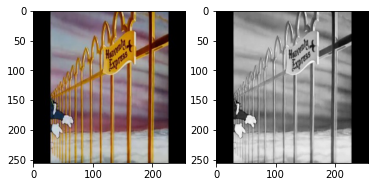

In [8]:
train_imgs = next(iter(trainloader))
print(train_imgs[0].shape)
print(train_imgs[1].shape)
train_img_to_show_bw = train_imgs[0][0][0]
train_img_to_show_rgb = train_imgs[1][0]
train_img_to_show_rgb = np.transpose((train_img_to_show_rgb+1)/2, (1,2,0))

fig, axes = plt.subplots(1,2)
axes[0].imshow(train_img_to_show_rgb)
axes[1].imshow(train_img_to_show_bw, cmap = 'gray')

In [0]:
class Loss:
    def __init__(self):
        self.loss = []
    
    def add(self, x):
        self.loss.extend(x)
    
    def length(self):
        return len(self.loss)

    def get_loss(self):
        return self.loss;

In [0]:
class AverageLoss:
    def __init__(self, base_path):
        self.gen = Loss()
        self.dis = Loss()
        self.index = 0
        self.base_path = base_path

  #Assuming order - gen, dis
    def add_loss(self,losses):
        self.gen.add(losses[0])
        self.dis.add(losses[1])

    def plot(self, iteration_factor = 10):
        plt.plot(self.gen.get_loss(), label = 'Generator')
        plt.plot(self.dis.get_loss(), label = 'Discriminator')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('{}/loss_curve_{}.png'.format(self.base_path, self.index))
        plt.show()
    
    def save(self, filename):
        save_dict = {'gen': self.gen, 'dis': self.dis,'index': self.index, 'base_path': self.base_path}
        filepath = '{}/Loss_Checkpoints/{}_{}'.format(self.base_path,filename, self.index)
        with open(filepath,'wb') as file:
            pickle.dump(save_dict,file)
        print('Losses have been saved!')
        self.index += 1
    
    def load(self, filename, index):
        filepath = '{}/Loss_Checkpoints/{}_{}'.format(self.base_path,filename, index)
        with open(filepath, 'rb') as file:
            save_dict = pickle.load(file)
            self.gen = save_dict['gen']
            self.dis = save_dict['dis']
            self.index = save_dict['index']
            self.base_path = save_dict['base_path']
        print('Checkpoint has been restored!')

# Data Loading has been done!
# Let's start with defining the Discriminator and Discriminator classes

In [0]:
class Discriminator(nn.Module):
    def __init__(self, image_size = 256, leaky_relu = 0.2):
        
        super(Discriminator, self).__init__()
        
        self.leaky_relu = nn.LeakyReLU(leaky_relu)
        self.sigmoid = nn.Sigmoid()
        
        #Considering input to be 256
        self.layer_1 = nn.Conv2d(3, 32, 4, padding= 1, stride= 2)
        self.layer_1_bn = nn.BatchNorm2d(32)
        #Output size is batch_size X 32 X 128 X 128
        
        self.layer_2 = nn.Conv2d(32, 64, 4, padding= 1, stride= 2)
        self.layer_2_bn = nn.BatchNorm2d(64)
        #Output size is batch_size X 64 X 64 X 64
        
        self.layer_3 = nn.Conv2d(64, 128, 4, padding= 1, stride= 2)
        self.layer_3_bn = nn.BatchNorm2d(128)
        #Output size is batch_size X 128 X 32 X 32
        
        self.layer_4 = nn.Conv2d(128, 256, 4, padding= 1, stride= 2)
        self.layer_4_bn = nn.BatchNorm2d(256)
        #Output size is batch_size X 256 X 16 X 16
        
        self.layer_5 = nn.Conv2d(256, 512, 4, padding= 1, stride= 2)
        self.layer_5_bn = nn.BatchNorm2d(512)
        #Output size is batch_size X 512 X 8 X 8
        
        self.layer_6 = nn.Conv2d(512,1, int(image_size/32), padding= 0, stride= 1)
        
        self._initialize_weights()
    
    def forward(self, x):
        #Considering x to be of shape (batch_size X 3 X image_size X image_size)
        x = self.leaky_relu(self.layer_1_bn(self.layer_1(x)))
        
        x = self.leaky_relu(self.layer_2_bn(self.layer_2(x)))
        
        x = self.leaky_relu(self.layer_3_bn(self.layer_3(x)))
        
        x = self.leaky_relu(self.layer_4_bn(self.layer_4(x)))
        
        x = self.leaky_relu(self.layer_5_bn(self.layer_5(x)))
        
        x = self.sigmoid(self.layer_6(x))
        
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, std= 0.02)
                nn.init.constant_(m.bias.data, 0)
                

In [0]:
class Generator_Unet(nn.Module):
    def __init__(self, image_size = 224):
        super(Generator_Unet, self).__init__()
        
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
        #Input is of shape(1 X 1 X image_size X image_size)
        self.layer_1 = nn.Conv2d(1,64, 4, padding= 1, stride= 2)
        self.layer_1_bn = nn.BatchNorm2d(64)
        #Output is of shape (1 X 64 X 128 X 128)
        
        self.layer_2 = nn.Conv2d(64,128, 4, padding= 1, stride= 2)
        self.layer_2_bn = nn.BatchNorm2d(128)
        #Output is of shape (1 X 64 X 64 X 64)
        
        self.layer_3 = nn.Conv2d(128,256, 4, padding= 1, stride= 2)
        self.layer_3_bn = nn.BatchNorm2d(256)
        #Output is of shape (1 X 64 X 32 X 32)
        
        self.layer_4 = nn.Conv2d(256,512, 4, padding= 1, stride= 2)
        self.layer_4_bn = nn.BatchNorm2d(512)
        #Output is of shape (1 X 64 X 16 X 16)
        
        self.layer_5 = nn.Conv2d(512,512, 4, padding= 1, stride= 2)
        self.layer_5_bn = nn.BatchNorm2d(512)
        #Output is of shape (1 X 64 X 8 X 8)
        
        self.layer_6 = nn.ConvTranspose2d(512, 512, 4, padding= 1, stride= 2)
        self.layer_6_bn = nn.BatchNorm2d(512)
        #Ouput shape 16 X 16
        
        self.layer_7 = nn.ConvTranspose2d(512, 256, 4, padding= 1, stride= 2)
        self.layer_7_bn = nn.BatchNorm2d(256)
        #Ouput shape 32 X 32
        
        self.layer_8 = nn.ConvTranspose2d(256, 128, 4, padding= 1, stride= 2)
        self.layer_8_bn = nn.BatchNorm2d(128)
        #Output shape 64 X 64
        
        self.layer_9 = nn.ConvTranspose2d(128, 64, 4, padding= 1, stride= 2)
        self.layer_9_bn = nn.BatchNorm2d(64)
        #Ouput shape 128 X 128
        
        self.layer_10 = nn.ConvTranspose2d(64, 3, 4, padding= 1, stride= 2)
        #Output shape is 256 X 256
        
        self._initialize_weights()
    
    def forward(self, x):
        
        x = self.relu(self.layer_1_bn(self.layer_1(x)))
        store_1 = x
        
        x = self.relu(self.layer_2_bn(self.layer_2(x)))
        store_2 = x
        
        x = self.relu(self.layer_3_bn(self.layer_3(x)))
        store_3 = x
        
        x = self.relu(self.layer_4_bn(self.layer_4(x)))
        store_4 = x
        
        x = self.relu(self.layer_5_bn(self.layer_5(x)))
        
        x = self.relu(self.layer_6_bn(self.layer_6(x)))
        x += store_4
        
        x = self.relu(self.layer_7_bn(self.layer_7(x)))
        x += store_3
        
        x = self.relu(self.layer_8_bn(self.layer_8(x)))
        x += store_2
        
        x = self.relu(self.layer_9_bn(self.layer_9(x)))
        x += store_1
        
        x = self.tanh(self.layer_10(x))
        
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, std= 0.02)
                nn.init.constant_(m.bias.data,0)

# Let us now define our Training class

In [0]:
class Model:
    def __init__(self, base_path = '', epochs = 10, learning_rate = 0.0002, image_size = 224, leaky_relu = 0.2, betas = (0.5,0.999), lamda = 100, image_format = 'png'):
        self.image_size = image_size
        self.leaky_relu_threshold = leaky_relu
        
        self.epochs = epochs
        self.lr = learning_rate
        self.betas = betas
        self.lamda = lamda
        self.base_path = base_path
        self.image_format = image_format
        self.count = 1
        
        self.gen = None
        self.dis = None
        self.gen_optim = None
        self.dis_optim = None
        self.model_type = None

        self.device = self.get_device()
        self.create_folder_structure()
    
    def get_device(self):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print('Using device:', device)
        print(torch.cuda.get_device_name(0))
        
        if device.type == 'cuda':
            print('Memory Usage -')
            print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
            return device
        else:
            return None

    def create_folder_structure(self):
        checkpoint_folder = self.base_path + '/checkpoints'
        loss_folder = self.base_path + '/Loss_Checkpoints'
        training_folder = self.base_path + '/Training Images'
        test_folder = self.base_path + '/Test Images'
        if not os.path.exists(checkpoint_folder):
            os.makedirs(checkpoint_folder)
        if not os.path.exists(loss_folder):
            os.makedirs(loss_folder)
        if not os.path.exists(training_folder):
            os.makedirs(training_folder)
        if not os.path.exists(test_folder):
            os.makedirs(test_folder)
    
    def initialize_model(self, model_type = 'unet'):
        
        all_models = ['unet', 'resnet']
        if(model_type not in all_models):
            raise Exception('This model type is not available!');

        if(model_type == 'unet'):
            self.gen = Generator_Unet(image_size= self.image_size)
            self.dis = Discriminator(image_size= self.image_size, leaky_relu= self.leaky_relu_threshold)
        elif(model_type == 'resnet'):
            self.gen = Generator_RESNET()
            self.dis = Discriminator(image_size= self.image_size, leaky_relu= self.leaky_relu_threshold)

        if(self.device != None):
            self.gen.cuda()
            self.dis.cuda()    
            
        self.gen_optim = optim.Adam(self.gen.parameters(), lr= self.lr, betas= self.betas)
        self.dis_optim = optim.Adam(self.dis.parameters(), lr= self.lr, betas= self.betas)
        
        self.model_type = model_type
        print('Model Initialized !')

    def train_model(self, trainloader, average_loss, eval = (False,None, None), save_model = (False, 25), display_test_image = (False, None, 25), change_lr = (False, 30)):
        
        mean_loss = nn.BCELoss()
        l1_loss = nn.L1Loss()
        
        self.gen.train()
        self.dis.train()
        
        iterations = 1
        batches = len(trainloader)
        print('Total number of batches in an epoch are : {}'.format(batches))

        sample_img_test = None
        if display_test_image[0]:
            sample_img_test, rgb_test_images = next(iter(display_test_image[1]))
            save_image((rgb_test_images[0].detach().cpu()+1)/2, '{}/Training Images/real_img.{}'.format(self.base_path, self.image_format))
            if self.device != None:
                sample_img_test = sample_img_test.cuda()        

        for i in range(self.epochs):
            
            if(eval[0] and (i % eval[2] == 0)):
                self.evaluate_L1_loss_dataset(eval[1], train = False)
                self.gen.train()

            running_gen_loss = 0
            running_dis_loss = 0
            
            if(change_lr[0] and (i+2)%change_lr[1] == 0):
                self.change_params(learning_rate = self.lr * 0.8)

            for gray_img, real_img in trainloader:
                
                batch_size = len(gray_img)
                zero_label = torch.zeros(batch_size)
                one_label = torch.ones(batch_size)
  
                if self.device != None:
                    gray_img = gray_img.cuda()
                    real_img = real_img.cuda()
                    zero_label = zero_label.cuda()
                    one_label = one_label.cuda()
                    
                #Discriminator loss
                self.dis_optim.zero_grad()
                fake_img = self.gen(gray_img)
                
                dis_real_loss = mean_loss(self.dis(real_img), one_label)
                dis_fake_loss = mean_loss(self.dis(fake_img), zero_label)
                    
                total_dis_loss = dis_fake_loss + dis_real_loss
                total_dis_loss.backward()
                self.dis_optim.step()
                    
                #Generator loss
                self.gen_optim.zero_grad()
                
                fake_img = self.gen(gray_img)
                gen_adv_loss = mean_loss(self.dis(fake_img),one_label)
                gen_l1_loss = l1_loss(fake_img.view(batch_size, -1), real_img.view(batch_size, -1))
            
                total_gen_loss = gen_adv_loss + self.lamda*gen_l1_loss
                total_gen_loss.backward()
                self.gen_optim.step()
                    
                running_dis_loss += total_dis_loss.item()
                running_gen_loss += total_gen_loss.item()                                
                
                if(display_test_image[0] and iterations % display_test_image[2] == 0):
                    self.gen.eval()
                    out_result = self.gen(sample_img_test)
                    out_result = out_result.detach().cpu()
                    out_result = (out_result[0] + 1)/2
                    save_image(out_result,'{}/Training Images/iteration_{}.{}'.format(self.base_path, iterations, self.image_format))
                    self.gen.train()
                
                
                if(save_model[0] and iterations % save_model[1] == 0):
                    self.save_checkpoint('checkpoint_iter_{}'.format(iterations), self.model_type)
                    average_loss.save('checkpoint_avg_loss')
                
                iterations += 1
            
            running_dis_loss /= (batches*1.0)
            running_gen_loss /= (batches*1.0)
            print('Epoch : {}, Generator Loss : {} and Discriminator Loss : {}'.format(i+1, running_gen_loss, running_dis_loss))
            save_tuple = ([running_gen_loss], [running_dis_loss])
            average_loss.add_loss(save_tuple)
        
        self.save_checkpoint('checkpoint_train_final', self.model_type)
        average_loss.save('checkpoint_avg_loss_final')


    def evaluate_model(self, loader, save_filename, no_of_images = 1):
        #Considering that we have batch size of 1 for test set
        if(self.gen == None or self.dis == None):
          raise Exception('Model has not been initialized and hence cannot be saved!');

        counter_images_generated = 0
        while(counter_images_generated < no_of_images):
          gray, rgb = next(iter(loader))
          
          if(self.device != None):
              gray = gray.cuda()
          
          filename = '{}/Test Images/{}_{}.{}'.format(self.base_path, save_filename, self.count, self.image_format)
          real_filename = '{}/Test Images/{}_{}_real.{}'.format(self.base_path, save_filename, self.count, self.image_format)
          real_gray_filename = '{}/Test Images/{}_{}_real_gray.{}'.format(self.base_path, save_filename, self.count, self.image_format)
          self.count += 1
          
          self.gen.eval()
          out = self.gen(gray)
          out = out[0].detach().cpu()
          out = (out+1)/2
          save_image(out, filename)
          
          gray_img = gray[0].detach().cpu()
          save_image(gray_img, real_gray_filename)

          real_img = (rgb[0].detach().cpu() +1)/2
          save_image(real_img, real_filename)

          counter_images_generated +=1
    
    def evaluate_L1_loss_dataset(self, loader, train = False):

        if(self.gen == None or self.dis == None):
            raise Exception('Model has not been initialized and hence cannot be evaluated!')
        
        loss_function = nn.L1Loss()
        self.gen.eval()
        total_loss = 0.0;
        iterations = 0;
        for gray, real in loader:
            iterations += 1
            if(self.device != None):
                gray = gray.cuda()
                real = real.cuda()

            gen_out = self.gen(gray)
            iteration_loss = loss_function(gen_out, real)
            total_loss += iteration_loss.item()
        total_loss = total_loss / (iterations * 1.0)
        train_test = 'test'
        if train:
          train_test = 'train'
        print('Total L1 loss over {} set is : {}'.format(train_test,total_loss))
        return total_loss;

    
    def change_params(self, epochs = None, learning_rate = None, leaky_relu = None, betas = None, lamda = None):
        if(epochs != None):
            self.epochs = epochs
            print('Changed the number of epochs to {}!'.format(self.epochs))
        if(learning_rate != None):
            self.lr = learning_rate
            print('Changed the learning rate to {}!'.format(self.lr))
        if(leaky_relu != None):
            self.leaky_relu_threshold = leaky_relu
            print('Changed the threshold for leaky relu to {}!'.format(self.leaky_relu_threshold))
        if(betas != None):
            self.betas = betas
            print('Changed the betas for Adams Optimizer!')
        if(betas != None or learning_rate != None):
            self.gen_optim = optim.Adam(self.gen.parameters(), lr= self.lr, betas= self.betas)
            self.dis_optim = optim.Adam(self.dis.parameters(), lr= self.lr, betas= self.betas)
            
        if(lamda != None):
            self.lamda = lamda
            print('Lamda value has been changed!')
    
    def save_checkpoint(self, filename, model_type = 'unet'):
        if(self.gen == None or self.dis == None):
            raise Exception('The model has not been initialized and hence cannot be saved !')
        
        filename = '{}/checkpoints/{}.pth'.format(self.base_path, filename)
        save_dict = {'model_type': model_type, 'dis_dict':self.dis.state_dict(), 'gen_dict': self.gen.state_dict(), 'lr': self.lr,
                    'epochs' : self.epochs, 'betas': self.betas, 'image_size':self.image_size, 
                     'leaky_relu_thresh' : self.leaky_relu_threshold, 'lamda' : self.lamda, 'base_path': self.base_path, 
                     'count' : self.count, 'image_format': self.image_format, 'device': self.device}
        
        torch.save(save_dict, filename)
        
        print('The model checkpoint has been saved !')
    
    def load_checkpoint(self, filename):
        filename = '{}/checkpoints/{}.pth'.format(self.base_path, filename)
        if(not pathlib.Path(filename).exists()):
            raise Exception('This checkpoint does not exist!')
        
        self.gen = None
        self.dis = None
        
        save_dict = torch.load(filename)
        
        self.betas = save_dict['betas']
        self.image_size = save_dict['image_size']
        self.epochs = save_dict['epochs']
        self.leaky_relu_threshold = save_dict['leaky_relu_thresh']
        self.lamda = save_dict['lamda']
        self.lr = save_dict['lr']
        self.base_path = save_dict['base_path']
        self.count = save_dict['count']
        self.image_format = save_dict['image_format']
        self.device = save_dict['device']

        self.initialize_model(model_type= save_dict['model_type'])
        
        self.gen.load_state_dict(save_dict['gen_dict'])
        self.dis.load_state_dict(save_dict['dis_dict'])
        
        print('The model checkpoint has been restored!')

In [14]:
model = None
torch.cuda.empty_cache()
gc.collect()
model = Model(base_path = global_path, image_size= image_size, image_format = image_format)
average_loss = AverageLoss(global_path)

Using device: cuda
Tesla P100-PCIE-16GB
Memory Usage -
Allocated: 0.0 GB
Cached:    0.0 GB


In [15]:
#model.load_checkpoint('checkpoint_train_final_200')
#average_loss.load('checkpoint_avg_loss_final',1)

Model Initialized !
The model checkpoint has been restored!
Checkpoint has been restored!


In [22]:
model.initialize_model(model_type= 'unet')

Model Initialized !


In [16]:
model.change_params(epochs=100)
model.change_params(learning_rate = 0.0001)
model.change_params(lamda = lamda)

Changed the number of epochs to 100!
Changed the learning rate to 0.0001!
Lamda value has been changed!


Total number of batches in an epoch are : 256
Total L1 loss over test set is : 0.08349434905103408


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch : 1, Generator Loss : 12.055510582402349 and Discriminator Loss : 0.33689023972692667
Epoch : 2, Generator Loss : 12.529317006468773 and Discriminator Loss : 0.262399925130012
Epoch : 3, Generator Loss : 13.267147030681372 and Discriminator Loss : 0.10273210327250126
Epoch : 4, Generator Loss : 12.982634199783206 and Discriminator Loss : 0.2946889365402967
Epoch : 5, Generator Loss : 12.263974407687783 and Discriminator Loss : 0.5297885933250654
Epoch : 6, Generator Loss : 12.710532577708364 and Discriminator Loss : 0.13750528252239747
Epoch : 7, Generator Loss : 12.855987153947353 and Discriminator Loss : 0.25111442044726573
Epoch : 8, Generator Loss : 12.625795189291239 and Discriminator Loss : 0.38612057938735234
Epoch : 9, Generator Loss : 12.514300998300314 and Discriminator Loss : 0.17207933933968889
Epoch : 10, Generator Loss : 13.472855180501938 and Discriminator Loss : 0.09379604243167705
Epoch : 11, Generator Loss : 12.996460411697626 and Discriminator Loss : 0.32989055

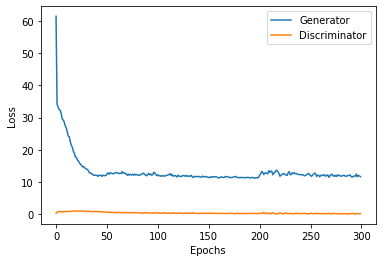

Total L1 loss over train set is : 0.03644617662939709
Total L1 loss over test set is : 0.08325449700350873


0.08325449700350873

In [17]:
model.train_model(trainloader, average_loss, save_model= (False, 10*batches_iter), 
              display_test_image=(True, validloader, batches_iter), change_lr = (True, 20),
              eval = (True, validloader, 25))
average_loss.plot()
model.evaluate_model(validloader, 'test', 5)
model.evaluate_model(trainloader, 'train', 5)
model.evaluate_L1_loss_dataset(trainloader, train = True)
model.evaluate_L1_loss_dataset(validloader, train = False)

In [0]:
#model.evaluate_L1_loss_dataset(trainloader, train = True)
#model.evaluate_L1_loss_dataset(validloader, train = False)

In [0]:
#Unet_200_b5